# Diet and Disease

This project will investigate the major causes of death in the world, as well as how one of these causes, heart disease, might be linked to diet!

In [404]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
np.set_printoptions(legacy='1.13')

from client.api.notebook import Notebook
ok = Notebook('project2.ok')
_ = ok.auth(inline=True)

Assignment: Project 2: Diet and Disease
OK, version v1.12.5

Successfully logged in as deruiwang@berkeley.edu


# Diet and Cardiovascular Disease

Death and its many causes are often a disconcerting topic for polite conversation. However, the more we know about it, the better equipped we are to prevent our early demise. As the acclaimed Professor Albus Dumbledore once said, "After all, to the well-organized mind, death is but the next great adventure."

In the following analysis, we will investigate the world's most dangerous killer: Cardiovascular Disease. Your investigation will take you across decades of medical research, and you'll look at multiple causes and effects across two different studies.

Here is a roadmap for this project:

* In Part 1, we'll investigate the major causes of death in the world during the past century (from 1900 to 2015).
* In Part 2, we'll look at data from the Framingham Heart Study, an observational study into cardiovascular health.
* In Part 3, we'll examine the clinical trials from the Minnesota Coronary Experiment and introduce our second dataset.
* In Part 4, we'll run a hypothesis test on our observed data from the Minnesota Coronary Experiment.
* In Part 5, we'll conclude the experiment and reflect on what we've learned about the relationship between diet and cardiovascular disease.

## Part 1: Causes of Death 

In order to get a better idea of how we can most effectively prevent deaths, we need to first figure out what the major causes of death are. Run the following cell to read in and view the `causes_of_death` table, which documents the death rate for major causes of deaths over the last century (1900 until 2015).

In [405]:
causes_of_death = Table.read_table('causes_of_death.csv')
causes_of_death.show(5)

Year,Cause,Age Adjusted Death Rate
2015,Heart Disease,168.5
2015,Cancer,158.5
2015,Stroke,37.6
2015,Accidents,43.2
2015,Influenza and Pneumonia,15.2


Each entry in the column **Age Adjusted Death Rate** is a death rate for a specific **Year** and **Cause** of death. 

The **Age Adjusted** specification in the death rate column tells us that the values shown are the death rates that would have existed if the population under study in a specific year had the same age distribution as the "standard" population, a baseline. This is so we can compare ages across years without worrying about changes in the demographics of our population.

**Question 1:** What are all the different causes of death in this dataset? Assign an array of all the unique causes of death to `all_unique_causes`.

In [406]:
all_unique_causes = causes_of_death.group('Cause').column('Cause')
sorted(all_unique_causes)

['Accidents', 'Cancer', 'Heart Disease', 'Influenza and Pneumonia', 'Stroke']

In [407]:
_ = ok.grade('q1_1')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2:** We would like to plot the death rate for each disease over time. To do so, we must create a table with one column for each cause and one row for each year.

Create a table called `causes_for_plotting`. It should have one column called `Year`, and then a column with age-adjusted death rates for each of the causes you found in Question 1. There should be as many of these columns in `causes_for_plotting` as there are causes in Question 1.

*Hint*: Use `pivot`, and think about how the `elem` function might be useful in getting the **Age Adjusted Death Rate** for each cause and year combination.

In [408]:
def elem(x):
    return x.item(0)

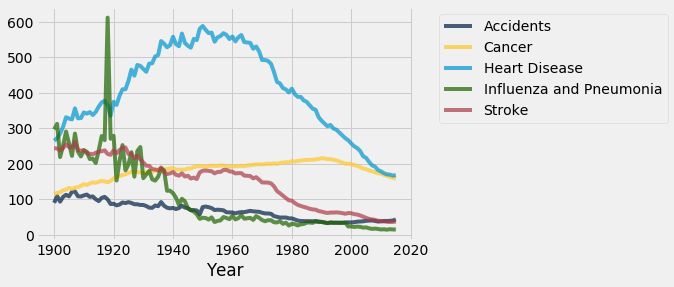

In [409]:
causes_for_plotting = causes_of_death.pivot('Cause','Year',values="Age Adjusted Death Rate", collect=elem)

# Do not change this line
causes_for_plotting.plot('Year')

Let's examine the graph above. You'll see that in the 1960s, the death rate due to heart disease steadily declines. Up until then, the effects of smoking, blood pressure, and diet on the cardiovascular system were unknown to researchers. Once these factors started to be noticed, doctors were able recommend a lifestyle change for at-risk patients to prevent heart attacks and heart problems.

Note, however, that the death rate for heart disease is still higher than the death rates of all other causes. Even though the death rate is starkly decreasing, there's still a lot we don't understand about the causes (both direct and indirect) of heart disease.

## Part 2: The Framingham Heart Study

The [Framingham Heart Study](https://en.wikipedia.org/wiki/Framingham_Heart_Study) is an observational study of cardiovascular health. The initial study followed over 5,000 volunteers for several decades, and followup studies even looked at their descendants. In this section, we'll investigate some of its key findings about diet, cholesterol, and heart disease.

Run the cell below to examine data for almost 4,000 subjects from the first wave of the study, collected in 1956.

In [410]:
framingham = Table.read_table('framingham.csv')
framingham

AGE,SYSBP,DIABP,TOTCHOL,CURSMOKE,DIABETES,GLUCOSE,DEATH,ANYCHD
39,106,70,195,0,0,77,0,1
46,121,81,250,0,0,76,0,0
48,127.5,80,245,1,0,70,0,0
61,150,95,225,1,0,103,1,0
46,130,84,285,1,0,85,0,0
43,180,110,228,0,0,99,0,1
63,138,71,205,0,0,85,0,1
45,100,71,313,1,0,78,0,0
52,141.5,89,260,0,0,79,0,0
43,162,107,225,1,0,88,0,0


Each row contains data from one subject. The first seven columns describe the subject at the time of their initial medical exam at the start of the study. The last column, `ANYCHD`, tells us whether the subject developed some form of heart disease at any point after the start of the study.

You may have noticed that the table contains fewer rows than subjects in the original study: this is because we are excluding subjects who already had heart disease as well as subjects with missing data.

### Section 1: Diabetes and the population

Before we begin our investigation into cholesterol, we'll first look at some limitations of this dataset. In particular, we will investigate ways in which this is or isn't a representative sample of the population by examining the number of subjects with diabetes.

[According to the CDC](https://www.cdc.gov/diabetes/statistics/slides/long_term_trends.pdf), the prevalence of diagnosed diabetes (i.e., the percentage of the population who have it) in the U.S. around this time was 0.93%. We are going to conduct a hypothesis test with the following null and alternative hypotheses:

**Null Hypothesis**: The probability that a participant within the Framingham Study has diabetes is equivalent to the prevalence of diagnosed diabetes within the population. (i.e., any difference is due to chance).

**Alternative Hypothesis**: The probability that a participant within the Framingham Study has diabetes is different than the prevalence of diagnosed diabetes within the population.

We are going to use the absolute distance between the observed prevalence and the true population prevalence as our test statistic. The column `DIABETES` in the `framingham` table contains a 1 for subjects with diabetes and a `0` for those without.

**Question 1**: What is the observed value of the statistic in the data from the Framingham Study? You should convert prevalences to proportions before calculating the statistic!

In [411]:
observed_diabetes_distance = abs(np.count_nonzero(framingham.column('DIABETES'))/framingham.num_rows-0.0093)
observed_diabetes_distance

0.01802951587714732

In [412]:
_ = ok.grade('q2_1_1')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2**: The array `diabetes_proportions` contains the proportions of the population without and with diabetes. Complete the following code to simulate 5000 values of the statistic under the null hypothesis.

In [413]:
diabetes_proportions = make_array(.9907, .0093)

diabetes_simulated_stats = make_array()
simulation=5000

for i in np.arange(simulation):
    simulated_stat = abs(sample_proportions(framingham.num_rows,diabetes_proportions).item(1)-0.0093)
    diabetes_simulated_stats = np.append(diabetes_simulated_stats,simulated_stat)
    
diabetes_simulated_stats

array([  7.01197293e-05,   1.89208745e-03,   7.01197293e-05, ...,
         1.75184800e-03,   1.75184800e-03,   4.50442478e-04])

In [414]:
_ = ok.grade('q2_1_2')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3**: Run the following cell to generate a histogram of the simulated values of your statistic, along with the observed value.

*Make sure to run the cell that draws the histogram, since it will be graded.*

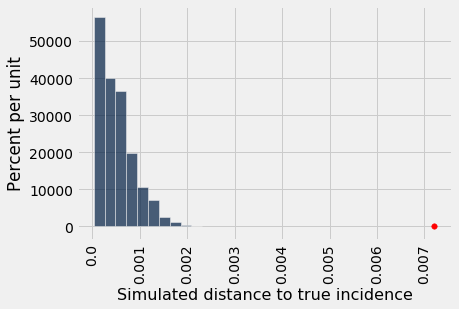

In [415]:
Table().with_column('Simulated distance to true incidence', diabetes_simulated_stats).hist()
plots.scatter(observed_diabetes_distance, 0, color='red', s=30)

**Question 4**: Based on the results of the test and the empirical distribution of the test statistic under the null, should you reject the null hypothesis?

I should.

**Question 5**: You know that the study was well-designed to represent the population. Why might there be a difference between the population and the sample? Assign the name `framingham_diabetes_explanations` to a list of the following explanations that **are possible and consistent** with the observed data and hypothesis test results.

1. Healthy (non-diabetic) people are more likely to volunteer for the study.
2. Diabetes was under-diagnosed in the population (i.e., there were a lot of people in the population who had diabetes but weren't diagnosed).
3. The relatively wealthy population in Framingham ate a luxurious diet high in sugar (high-sugar diets are a known cause of diabetes).
4. The Framingham Study subjects were older on average than the general population, and therefore more likely to have diabetes.


In [416]:
framingham_diabetes_possibilities = [1,2,3,4]
framingham_diabetes_possibilities

[1, 2, 3, 4]

In [417]:
_ = ok.grade('q2_1_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



In real-world studies, getting a truly representative random sample of the population is often incredibly difficult. Even just to accurately represent all Americans, a truly random sample would need to examine people across geographical, socioeconomic, community, and class lines (just to name a few). For a study like this, scientists would also need to make sure the medical exams were standardized and consistent across the different people being examined. In other words, there's a tradeoff between taking a more representative random sample and the cost of collecting all the data from the sample.

The Framingham study collected high-quality medical data from its subjects, even if the subjects may not be a perfect representation of the population of all Americans. This is a common issue that data scientists face: while the available data aren't perfect, they're the best we have. The Framingham study is generally considered the best in its class, so we'll continue working with it while keeping its limitations in mind.

(For more on representation in medical study samples, you can read these recent articles from [NPR](https://www.npr.org/sections/health-shots/2015/12/16/459666750/clinical-trials-still-dont-reflect-the-diversity-of-america) and [Scientific American](https://www.scientificamerican.com/article/clinical-trials-have-far-too-little-racial-and-ethnic-diversity/)).

### Section 2: Cholesterol and Heart Disease

In the remainder of this question, we are going to examine one of the main findings of the Framingham study: an association between serum cholesterol (i.e., how much cholesterol is in someone's blood) and whether or not that person develops heart disease.

We'll use the following null and alternative hypotheses:

**Null Hypothesis:** In the population, the distribution of cholesterol levels among those who get heart disease is the same as the distribution of cholesterol levels
among those who do not.

**Alternative Hypothesis:** The cholesterol levels of people in the population who get
heart disease are higher, on average, than the cholesterol level of people who do not.

**Question 1:** From the provided Null and Alternative Hypotheses, what seems more reasonable to use, A/B Testing or the Standard Hypothesis Testing? Assign the variable `reasonable_test` to one of the following choices. 

1. A/B Testing
2. Standard Hypothesis Test

In [418]:
reasonable_test = 1
reasonable_test

1

In [419]:
_ = ok.grade('q2_2_1')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2:** Now that we have a null hypothesis, we need a test statistic. Explain and justify your choice of test statistic in two sentences or less.

*Hint*: Remember that larger values of the test statistic should favor the alternative over the null.

**Test Statistic:** 

the difference of the mean level of serum cholesterol between the group has heart disease and the group that does not have heart disease (average serum cholesterol of the heart disease group - average serum cholesterol of the non-heart-disesase group).

If the test statistics is small, which means the difference of the level of serum cholesterol between two groups are small, which cannot reject the null hypothesis, and vice versa.

**Question 3**: Write a function that computes your test statistic. It should take a table with two columns, `TOTCHOL` and `ANYCHD`, and compute the test statistic you described above. 

In [420]:
def compute_framingham_test_statistic(tbl):
    grouped_table=tbl.group('ANYCHD',np.average)
    return abs(grouped_table.column('TOTCHOL average').item(1)-grouped_table.column('TOTCHOL average').item(0))


In [421]:
_ = ok.grade('q2_2_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4**: Use the function you defined above to compute the observed test statistic, and assign it to the name `framingham_observed_statistic`.

In [422]:
framingham_observed_statistic = compute_framingham_test_statistic(framingham)
framingham_observed_statistic

16.635919905689406

In [423]:
_ = ok.grade('q2_2_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now that we have defined hypotheses and a test statistic, we are ready to conduct a hypothesis test. We'll start by defining a function to simulate the test statistic under the null hypothesis, and then use that function 1000 times to understand the distribution under the null hypothesis.

**Question 5**: Write a function to simulate the test statistic under the null hypothesis. 

The `simulate_framingham_null` function should simulate the null hypothesis once (not 1000 times) and return the value of the test statistic for that simulated sample.

In [424]:
def simulate_framingham_null():
    shuffled_frame = framingham.select('TOTCHOL').sample(with_replacement=False).column('TOTCHOL')
    sim_table_frame = Table().with_column('ANYCHD',framingham.column("ANYCHD"),'TOTCHOL',shuffled_frame)
    return compute_framingham_test_statistic(sim_table_frame)

In [425]:
# Run your function once to make sure that it works.
simulate_framingham_null()

2.2871522151953627

In [426]:
_ = ok.grade('q2_2_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 6**: Fill in the blanks below to complete the simulation for the hypothesis test. Your simulation should compute 1000 values of the test statistic under the null hypothesis and store the result in the array framingham_simulated_stats.

*Hint*: You should use the function you wrote above in Question 3.

*Note*: Warning: running your code might take a few minutes!  We encourage you to check your `simulate_framingham_null()` code to make sure it works correctly before running this cell. 

In [427]:
framingham_simulated_stats = make_array()

for i in np.arange(1000):
    sim_stat = simulate_framingham_null()
    framingham_simulated_stats = np.append(framingham_simulated_stats,sim_stat)

The following line will plot the histogram of the simulated test statistics, as well as a point for the observed test statistic. Make sure to run it, as it will be graded. 

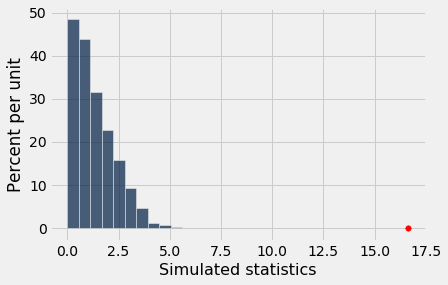

In [428]:
Table().with_column('Simulated statistics', framingham_simulated_stats).hist()
plots.scatter(framingham_observed_statistic, 0, color='red', s=30)

**Question 7**: Compute the p-value for this hypothesis test, and assign it to the name `framingham_p_value`.

*Hint*: One of the key findings of the Framingham study was a strong association between cholesterol levels and heart disease. If your p-value doesn't match up with this finding, you may want to take another look at your test statistic and/or your simulation.

In [429]:
framingham_p_value = np.count_nonzero(framingham_simulated_stats>=framingham_observed_statistic)/len(framingham_simulated_stats)
framingham_p_value

0.0

In [430]:
_ = ok.grade('q2_2_7')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 8**: Despite the Framingham Heart Study's reputation as a well-conducted and rigorous study, it has some major limitations. Give one specific reason why it can't be used to say that high cholesterol *causes* heart disease.


It is an observational study, which means some other factors might also influencing the rate of heart disease. With the assumption that chocolate causes heart disease and high cholesterol, people who eats chocolate will have high cholesterol. However, it is chocolate that causes heart disease rather than high cholesterol.

Similar studies from the 1950s found positive associations between diets high in saturated fat, high cholesterol, and incidence of heart disease. In 1962, the U.S. Surgeon General said:

*"Although there is evidence that diet and dietary habits may be implicated in the development of coronary heart disease and may be significant in its prevention or control, at present our only research evidence is associative and not conclusive."*

#### Congratulations, you have reached the checkpoint! Run the submit cell below to generate the checkpoint submission.

In [431]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'project2.ipynb'.
Submit... 100% complete
Submission successful for user: deruiwang@berkeley.edu
URL: https://okpy.org/cal/data8/fa18/project2/submissions/32Dy8p



## Part 3: Causality, the National Diet-Heart Study, and the Minnesota Coronary Experiment

To establish a causal link between saturated fat intake, serum cholesterol, and heart disease, a group of doctors in the US established the National Heart-Diet Study. The study was based in 6 centers: Baltimore, Boston, Chicago, Minneapolis-St. Paul, Oakland, and Faribault, MN. The first 5 centers recruited volunteers from the local population: volunteers and their families were asked to adjust their diet to include more or less saturated fat.

You may already have a strong intuition about what the doctors concluded in their findings, but the evidence from the trial was surprisingly complex.

**Question 1**: Why might the data from the National Heart-Diet Study not be enough to determine causality? Describe one specific limitation of the data from these first 5 centers in the study.

*Hint*: what is the main problem with fad diets?

The participants of the study are all volunteers. They adjust their own diet but the food is not directly provided by the researchers. It is hard to stick to certain kind of diet and the amount for a household if they have to get their own food, just as it is hard for someone who wants to lose weight to stick on fad diets.

The sixth center was organized by Dr. Ivan Frantz, and its study was known as the Minnesota Coronary Experiment. Dr. Frantz was a strong proponent of reducing saturated fats to prevent death from heart disease. He believed so strongly in the idea that he placed his household on a strict diet very low in saturated fats. The main difference between the Minnesota Coronary Experiment and the rest of the National Diet-Heart Study was the setting. While the other centers in the study looked at volunteers, Dr. Frantz conducted his study at Faribault State Hospital, which housed patients who were institutionalized due to disabilities or mental illness.

In this institution, the subjects were randomly divided into two equal groups: half of the subjects, the **control group**, were fed meals cooked with saturated fats, and the other half, the **diet group**, were fed meals cooked with polyunsaturated fats. For example, the diet group's oils were replaced with corn oils and their butter was replaced with margarine. The subjects did not know which food they were getting, to avoid any potential bias or placebo effect. This type of study is known as a **blind** study.

Although standards for informed consent in participation weren't as strict then as they are today, the study was described as follows:

*"No consent forms were required because the study diets were considered to be acceptable as house diets and the testing was considered to contribute to better patient care.  Prior to beginning the diet phase, the project was explained and sample foods were served. Residents were given the opportunity to decline participation."*

Despite the level of detail and effort in the study, the results of the study were never extensively examined until the late 21st century. Over 40 years after the data were collected, Dr. Christopher Ramsden heard about the experiment, and asked Dr. Frantz's son Robert to uncover the files in the Frantz family home's dusty basement. You can learn more about the story of how the data was recovered on the [Revisionist History podcast](http://revisionisthistory.com/episodes/20-the-basement-tapes) or in [Scientific American magazine](https://www.scientificamerican.com/article/records-found-in-dusty-basement-undermine-decades-of-dietary-advice/).

**Question 2:** While the data from such a study may be useful scientifically, it also raises major ethical concerns. Describe at least one ethical problem with the study conducted at Faribault State Hospital.

*Hint*: There isn't necessarily a single right or wrong answer to this question. If you're not sure, some areas of consideration may be the study organizers' selection of participants for the study, as well as their justification for not using consent forms. You could also ask yourself how the project might have been explained to the patients prior to the diet phase, and to what degree were they capable of consent.

The participants for the study are selected from the nursing house or in state mental health hospital.  The participants are already patients with disabilities or mental illness, they may not fully understand the risk and the outcome of the research

In recent years, poor treatment of patients at Faribault State Hospital (and other similar institutions in Minnesota) has come to light: the state has recently [changed patients' gravestones from numbers to their actual names](https://www.tcdailyplanet.net/minnesota-saying-sorry-treatment-persons-disabilities/), and [apologized for inhumane treatment of patients](https://www.tcdailyplanet.net/minnesota-saying-sorry-treatment-persons-disabilities/).

Unfortunately, the data for each individual in the 1968 study is not available; only summary statistics are available.  Therefore, in this project we create artificial synthetic data, based on those summary statistics.

In order to test whether eating diet actually reduced serum cholesterol levels, we need to create a table with one row for each participant in the study, as well as how their serum cholesterol changed. There were 1179 subjects in the diet group and 1176 subjects in the control group who had their serum cholesterol changes measured. 

The study measured the serum cholesterol at the start and end of the study, then used this to compute the percentage change for each individual.  Then, they computed the average and standard deviation of these percentage changes for each study group. We have these summary statistics: for those who received the unsaturated fat diet, the serum cholestorol decreased by 13.8% on average, with a standard deviation of 13%.  For those in the control group, the percentage change decreased by 1% on average, with a standard deviation of 14.5%.  We used these statistics to generate random synthetic percentage change levels for each individual, making an assumption about the distribution fo these changes.  We have saved this data in `serum_cholesterol.csv`.  We read this table into `serum_cholesterol` below.

In [432]:
serum_cholesterol = Table.read_table('serum_cholesterol.csv')
serum_cholesterol

Condition,Change in Serum Cholesterol
Diet,-8.36662
Diet,-23.6885
Diet,-28.985
Diet,-10.9341
Diet,-17.9041
Diet,-11.7145
Diet,-13.6215
Diet,-2.2387
Diet,-2.03579
Diet,-13.5746


After determining if serum cholesterol is actually lowered by this new diet, we will see whether or not death rates were reduced as well. The following table is a summarized version of the data collected in the experiment. 

In [433]:
mortality_summary = Table.read_table('mortality_summary.csv')
mortality_summary

Age,Condition,Total,Deaths,CHD Deaths
0-34,Diet,1367,3,0
35-44,Diet,728,3,0
45-54,Diet,767,14,4
55-64,Diet,870,35,7
65+,Diet,953,190,42
0-34,Control,1337,7,1
35-44,Control,731,4,1
45-54,Control,816,16,4
55-64,Control,896,33,12
65+,Control,958,162,34


**Question 3:** The numbers of deaths in the Deaths column above are not specific to cardiovascular disease. For our tests, we are going to use the total number of deaths instead of the number of CHD deaths. If a hypothesis test shows that the rate of deaths in the diet group is different from the rate of deaths in the control group, which of the following are valid conclusions from the test? Assign the name `mortality_valid_conclusions` to a list of numbers.

1. Eating a diet rich in unsaturated fats causes an increased/decreased risk of death.
2. Eating a diet rich in unsaturated fats causes/prevents cardiovascular disease.
3. Lower cholesterol causes an increased/decreased risk of cardiovascular disease.
4. It is impossible to determine any causal relationship between any of these factors, even if the test shows an association.

In [434]:
mortality_valid_conclusions = [1]
mortality_valid_conclusions

[1]

In [435]:
_ = ok.grade('q3_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



To help with our simulations, we are going to expand the `mortality_summary` table so that we have one row for every subject in the experiment. Our goal is to put this into a table called `minnesota_data`.

**Question 4:** Using all of the notes below, complete the code below to create a table with four columns: "Age", "Condition", "Participated" and "Died". Each row should contain a specific patient and should have their age group and condition as specified in the `mortality_summary` table, a `True` in the "Participated" column since everyone participated in the experiment, and either a `True` or `False` in the "Died" column, depending on if they are alive or dead. 

The total number of rows of `minnesota_data` should be the same as the number of participants summarized in the mortality_summary table. 

*Hint*: The most useful notes from below will be the final three; how to get an item out of a row, passing in just one value into the second argument of `with_column`, and how to iterate over rows. Make sure you use the other two notes to understand what the rest of this code is doing.  

The following few notes will all be helpful to finish and understand the code below: 

* `tbl1.append(tbl2)` adds all of the rows of `tbl2` into `tbl1`, assuming they have the same column names 
* `np.arange(5) < 3` returns the following array: `[True, True, True, False, False]`
* `row.item(x)` returns the item in column `x` in a specific row of a table
*  If `my_table` has 10 rows. Then, `my_table.with_column('Num', val)` adds an array of length 10, with each element being val, as a new column of the table. 
*  To iterate over all rows of a table, you can write `for row in tbl.rows:`

In [436]:
minnesota_data = Table(['Age', 'Condition', 'Died', 'Participated'])

for row in mortality_summary.rows:
    i = np.arange(0, row.item('Total'))
    t = Table().with_column('Died', i < row.item('Deaths'))
    t = t.with_column('Age',row.item('Age') )
    t = t.with_column('Condition', row.item('Condition'))
    t = t.with_column('Participated', True)
    minnesota_data.append(t)

minnesota_data

Age,Condition,Died,Participated
0-34,Diet,True,True
0-34,Diet,True,True
0-34,Diet,True,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True


In [437]:
_ = ok.grade('q3_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Part 4: Running a Hypothesis Test

Now that we have two clean datasets from the Minnesota Coronary Experiment to work with, we can focus on determining causal links. Assuming that these randomized controlled experiments are samples from the larger population, we can work on using the inference techniques discussed so far in the course to answer the following questions: 

* Does changing saturated fats to polyunsaturated fats in a person's diet **decrease their serum cholestrol levels**? 


* Does changing saturated fats to polyunsaturated fats in a person's diet **affect their risk of death**? 

### Section 1: Reducing Serum Cholesterol 

First, we want to test whether the unsaturated fat diet changes serum cholesterol levels. To do so, we will need the `serum_cholesterol` table. Remember that there are two unique values in the 'Condition' column: 'Diet' and 'Control'.

In [438]:
serum_cholesterol

Condition,Change in Serum Cholesterol
Diet,-8.36662
Diet,-23.6885
Diet,-28.985
Diet,-10.9341
Diet,-17.9041
Diet,-11.7145
Diet,-13.6215
Diet,-2.2387
Diet,-2.03579
Diet,-13.5746


**Question 1:** State precisely a null hypothesis and an alternative hypothesis which can help us determine if the unsaturated fat diet *decreases* serum cholesterol levels as compared to the control diet. 

**Null Hypothesis:** In the population, people who have the unsatured fat diet has the same serum cholesterol level comparing to people who have the the satured fat diet. The difference in sample is due to chance.

**Alternative Hypothesis:** In the population, people who have the unsatured fat diet has the lower serum cholesterol level, on average, comparing to people who have the the satured fat diet. 

In order to differentiate between our two hypotheses above, we consider the difference in the average of the percentage changes between the control group and the diet group.

**Question 2:** Do larger values of the test statistic point towards the  null hypothesis or the alternative hypothesis? Assign `larger_chol_stat` to either 1 if it's the null, or 2 if it's the alternative. 

In [439]:
larger_chol_stat = 2

In [440]:
_ = ok.grade('q4_1_2')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3:** Define a function `compute_chol_test_statistic` which takes in a table just like `serum_cholesterol` and returns the test statistic of the given data. Remember that the "Change in Serum Cholesterol" column in the provided `tbl` for `compute_chol_test_statistic` will already have % changes.

In [441]:
def compute_chol_test_statistic(tbl):
    grouped_chol = tbl.group('Condition', np.mean).column("Change in Serum Cholesterol mean")
    percent_change_diet_chol = grouped_chol.item(1)
    percent_change_control_chol = grouped_chol.item(0)
    return percent_change_control_chol-percent_change_diet_chol

In [442]:
_ = ok.grade('q4_1_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 4:** Assign `chol_observed_statistic` to the value of the test statistic on the observed data. 

In [443]:
chol_observed_statistic = compute_chol_test_statistic(serum_cholesterol)
chol_observed_statistic

12.829344627886611

In [444]:
_ = ok.grade('q4_1_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 5:** The next step in our hypothesis test is to simulate what we might observe if the null hypothesis were true. Describe the steps needed to simulate the test statistic under the null hypothesis. Then, write a function to simulate one value of the statistic under the null hypothesis.

**Step 1** shuffle all the serum cholesterol level

**Step 2** Assign some of the serum cholesterol level to group with unstatured fat diet and the rest to group with statured fat diet, maintaing the two sample sizes

**Step 3** Find the difference between the average of the two shuffled groups

**Step 4** Repeat Step 1-3 

In [445]:
def simulate_chol_change_null():
    shuffled_chol = serum_cholesterol.sample(with_replacement=False).column("Change in Serum Cholesterol")
    sim_table_chol = serum_cholesterol.drop("Change in Serum Cholesterol").with_column("Change in Serum Cholesterol",shuffled_chol)
    return compute_chol_test_statistic(sim_table_chol)

In [446]:
# Run this cell to check that your function works.
simulate_chol_change_null()

-0.4209899381088418

**Question 6:** Simulate 1000 values of the test statistic by simulating taking a sample under the null hypothesis multiple times and assign this collection of test statistics to `chol_simulated_stats`. Put the test statistics into a one column table with 1000 rows called `chol_simulated_table`. 

*Note*: Your code might take a couple of minutes to run.

In [447]:
chol_simulated_stats = make_array()

for i in np.arange(1000):
    sim_stat = simulate_chol_change_null()
    chol_simulated_stats = np.append(chol_simulated_stats,sim_stat)


chol_simulated_table = Table().with_column('Simulated Test Statistics', chol_simulated_stats)

In [448]:
_ = ok.grade('q4_1_6')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



The following line plots the histogram of the simulated test statistics, as well as a point for the observed test statistic. Make sure to run it, as it will be graded. 

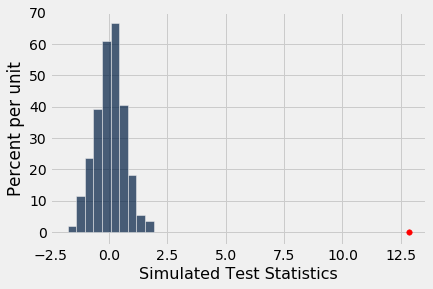

In [449]:
chol_simulated_table.hist()
plots.scatter(chol_observed_statistic, 0, color='red', s=30)

**Question 7:** Without calculating any p-values, can we conclude from the test that the change in diet **causes** a larger percentage difference in serum cholesterol levels over time? Explain your answer. 

Yes. Because the empirical value is way too big. It is out of the distribution of the simulated sample under the null hypothesis. So the p-value is not necessarily needed to demonstrate the causality. Also, the random assignment of treatment to the two groups ensures that there is no confounding variable that could affect the conclusion of causality. So we can conclude from the test that the change in diet causes a larager percentage difference in serum cholesterol levels over time without p-values.

**Question 8:** Assign `cholesterol_conclusion` to 1, 2, or 3, where the number chosen corresponds to the conclusion that we can make from this study.

1. The results of this analysis indicate that changing saturated fats to polyunsaturated fats in a person's diet decreases their serum cholesterol levels.  
2. The results of this analysis indicate that changing saturated fats to polyunsaturated fats in a person's diet does not decrease their serum cholesterol levels.  
3. The results of this analysis do not allow us to draw any conclusions about the effect of changing saturated fats to polyunsaturated fats in a person's diet on their serum cholesterol levels.

In [450]:
cholesterol_conclusion = 1
cholesterol_conclusion

1

In [451]:
_ = ok.grade('q4_1_8')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Section 2: Reducing Death Rates

In the previous section, we made a decision on whether dietary change affects the change in serum cholesterol levels. We have not yet, however, explored how the change in diet affects death rates among the subjects. To explore this, we move our attention to the `minnesota_data` table. 

In [452]:
minnesota_data

Age,Condition,Died,Participated
0-34,Diet,True,True
0-34,Diet,True,True
0-34,Diet,True,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True
0-34,Diet,False,True


**Question 1:** Set up a null hypothesis and an alternative hypothesis that we can use to answer whether or not the unsaturated fat diet causes different rates of death in the two groups.

**Null Hypothesis:** In the population, people who have the unstatured fat diet have the same rate of death comparing to people who have statured fat diet. The difference of death rate of the two group is by chance.

**Alternative Hypothesis:** In the population, people who have the unstatured fat diet do not have the same rate of death comparing to people who have statured fat diet. The difference of death rate of the two group is not by chance.

**Question 2:** Create a table named `summed_mn_data`, with three columns and two rows. The three columns should be "Condition", "Died sum", and "Participated sum". There should be one row for the diet group and one row for the control group, and each row should encode the total number of people who participated in that group and the total number of people who died in that group. 

In [453]:
summed_mn_data = minnesota_data.group("Condition",sum).drop('Age sum')
summed_mn_data

Condition,Died sum,Participated sum
Control,222,4738
Diet,245,4685


In [454]:
_ = ok.grade('q4_2_2')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3:** In thinking of a test statistic, one researcher decides that the absolute difference in the number of people who died in the control group and the number of people who died in the diet group is a sufficient test statistic. Give one **specific** reason why this test statistic will not work. 

Because the participated sum of the two groups are different, comparing the different between died sum is meaningless.

To combat the problem above, we instead decide to use the the absolute difference in hazard rates between the two groups as our test statistic. The *hazard rate* is defined as the proportion of people who died in a specific group out of the total number who participated in the study from that group. 

**Question 4:** Define a new table `summed_mn_hazard_data` that contains the columns of `summed_mn_data` along with an additional column, `Hazard Rate`, that contains the hazard rates for each condition.

In [455]:
summed_mn_hazard_data = summed_mn_data.with_column('Hazard Rate', summed_mn_data.column("Died sum")/summed_mn_data.column("Participated sum"))
summed_mn_hazard_data

Condition,Died sum,Participated sum,Hazard Rate
Control,222,4738,0.0468552
Diet,245,4685,0.0522946


In [456]:
_ = ok.grade('q4_2_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 5:** Define a function `compute_hazard_difference` which takes in a table like `summed_mn_hazard_data` and returns the absolute difference between the hazard rates of the control group and the diet group. Use it to get the observed test statistic and assign it to `death_rate_observed_statistic`.

In [457]:
def compute_hazard_difference(tbl):
    return abs(tbl.column("Hazard Rate").item(1)-tbl.column("Hazard Rate").item(0))

death_rate_observed_statistic =compute_hazard_difference(summed_mn_hazard_data)
death_rate_observed_statistic

0.005439343927004493

In [458]:
_ = ok.grade('q4_2_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 6:** We are now in a position to run a hypothesis test to help differentiate between our two hypothesis using our data. Define a function `test` which takes in a table like `minnesota_data`. It simulates samples and calculates the rate differences for these samples under the null hypothesis 500 times, and uses them to return a P-Value with respect to our observed data. Note that your function should use the values in `t`, and should not refer to `minnesota_table`!

*Hint:* This is a very long, involved problem. Start by outlining the steps you'll need to execute in this function and address each separately. Small steps and comments will be very helpful. You've already written a lot of key steps!

Note: Your code might take a long time to run.

In [459]:
def test(t):
    result_summary=make_array()
    for i in np.arange(500):
        shuffled_condition=t.select('Condition').sample(with_replacement=False).column('Condition')
        shuffled_dataset=t.drop('Age','Condition').with_column("Condition",shuffled_condition)
        summed_data=shuffled_dataset.group("Condition",np.sum)
        summed_data_rate= summed_data.with_column('Hazard Rate', summed_data.column("Died sum")/summed_data.column("Participated sum"))
        result=compute_hazard_difference(summed_data_rate)
        result_summary=np.append(result_summary,result)
        
    p=sum(result_summary>=death_rate_observed_statistic)/500
        
        
    

    return p
    

our_p_value = test(minnesota_data)
our_p_value

0.20799999999999999

In [460]:
_ = ok.grade('q4_2_6')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 7:** Using the P-Value above, what can we conclude about if the change in diet causes a difference in death rate? Assume a normal p-value cutoff of .05. 

The change in diet does not cause a difference in death rate. The p-value is quite big. It is much greater than the cutoff of 0.05. This empirical statistics is not statistically significant. 

## Part 5: Conclusion

We've almost made it to the end of this analysis. You, as an investigative data scientist, have explored the world's leading causes of death, identified the largest cause of death known to us in the last century, and looked at one of the most important data sets that explains what leads to that cause of death. We've recreated Dr. Frantz's data, run our own experiments, and examined important external factors. It's now time to reflect on what we've discovered.

**Question 1:** In about 3-5 sentences, explain what you have learned throughout this project. Does replacing saturated fats with unsaturated fats cause a change in serum cholesterol? Does it cause a different death rate? What other factors are important to consider? 

Replacing satured fats with unsaturated fats does cause a chage in serum choesterol. However, the decrease of the level of serum choesterol does not cause the death rate to change. Also, it is important to consider the subject of the sample when doing a study. It should be randomnized to reduce the influence of the confounding factors. The study should also be conducted ethically ,even when we are trying to conduct a blind study, we should make sure the subjects consent about the treatment

Congratulations! You have completed your own large scale case study into cause and effect surrounding one of the world's deadliest killers: cardiovascular disease. Your investigation you has taken you through two important data sets and across decades of medical research.

Run the next cell to submit the project. 

In [ ]:
_ = ok.submit()

### Further reading

If you're interested in learning more, you can check out these articles:

* [Origin story of the Framingham Heart Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1449227/)
* [Recent paper about Minnesota findings](https://www.bmj.com/content/353/bmj.i1246)
* [National Diet-Heart Study initial report](https://jamanetwork.com/journals/jama/article-abstract/666261)
* [National Diet-Heart Study final report](http://www.epi.umn.edu/cvdepi/study-synopsis/national-diet-heart-study/)

In [403]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t